# Train MNIST model on natural samples

In [1]:
import numpy as np
import pandas as pd
from torch import nn, optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import transforms, datasets
from multiprocessing import cpu_count
import matplotlib.pyplot as plt
import torch
import olympic

In [2]:
if torch.cuda.is_available():
    DEVICE = 'cuda'
else:
    DEVICE = 'cpu'

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train = datasets.MNIST('../data/', train=True, transform=transform, download=True)
val = datasets.MNIST('../data/', train=False, transform=transform, download=True)

train_loader = DataLoader(train, batch_size=128, num_workers=cpu_count())
val_loader = DataLoader(val, batch_size=128, num_workers=cpu_count())

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(1024, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 1024)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)

In [7]:
model = Net().to(DEVICE)
optimiser = optim.SGD(model.parameters(), lr=0.1)
loss_fn = nn.CrossEntropyLoss()

In [8]:
history_natural = olympic.fit(
    model,
    optimiser,
    loss_fn,
    dataloader=train_loader,
    epochs=20,
    metrics=['accuracy'],
    prepare_batch = lambda batch: (batch[0].to(DEVICE), batch[1].to(DEVICE)),
    callbacks=[
        olympic.callbacks.Evaluate(val_loader),
        olympic.callbacks.ReduceLROnPlateau(patience=5)
    ]
)

Epoch 1:   0%|          | 0/469 [00:00<?, ?it/s]

Begin training...


Epoch 20: 100%|██████████| 469/469 [00:04<00:00, 58.13it/s, loss=0.0116, accuracy=0.997, val_loss=0.0277, val_accuracy=0.991]

Finished.


In [9]:
olympic.evaluate(model, val_loader, metrics=['accuracy'],
                 prepare_batch = lambda batch: (batch[0].to(DEVICE), batch[1].to(DEVICE)))

{'val_accuracy': 0.9911}

# $L_2$ bounded adversary

In [10]:
import sys
from typing import Union, Callable, Tuple
sys.path.append('../adversarial/')
sys.path.append('../')
from functional import boundary, iterated_fgsm, local_search, pgd

In [11]:
x, y = val[0]
x = x.unsqueeze(0).to(DEVICE)
y = y.unsqueeze(0).to(DEVICE)
x_adv_pgd = pgd(model, x, y, torch.nn.CrossEntropyLoss(), k=40, step=0.1, eps=2.5, norm=2)
print('L2 distance = ', (x - x_adv_pgd).norm(2))
print('Linf distance = ', (x - x_adv_pgd).norm(float('inf')))
print('Adversarial prediction = ', model(x_adv_pgd).argmax(dim=1))

L2 distance =  tensor(2.4987, device='cuda:0')
Linf distance =  tensor(0.4518, device='cuda:0')
Adversarial prediction =  tensor([9], device='cuda:0')


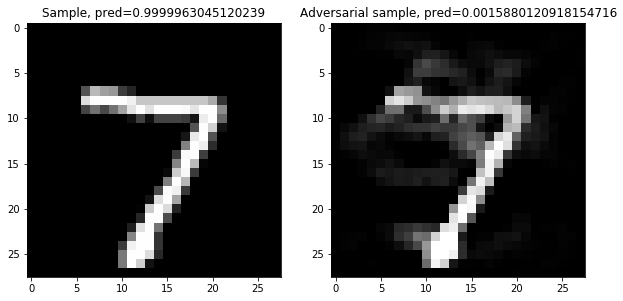

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))

axes[0].imshow(x[0, 0].cpu().numpy(), cmap='gray')
axes[0].set_title(f'Sample, pred={model(x).softmax(dim=1)[0, y].item()}')

axes[1].imshow(x_adv_pgd[0, 0].cpu().numpy(), cmap='gray')
axes[1].set_title(f'Adversarial sample, pred={model(x_adv_pgd).softmax(dim=1)[0, y].item()}')

plt.show()

In [13]:
def eval_pgd_attack(model, k, eps, step):
    total = 0
    acc = 0
    for x, y in val_loader:
        total += x.size(0)

        x_adv = pgd(model, x.to(DEVICE), y.to(DEVICE), torch.nn.CrossEntropyLoss(), k=k, step=step, eps=eps, norm=2)

        y_pred = model(x_adv)

        acc += olympic.metrics.accuracy(y.to(DEVICE), y_pred) * x.size(0)

    return acc/total

In [16]:
pgd_attack_range = np.arange(0.0, 8.1, 0.25)
pgd_acc = []
for eps in pgd_attack_range:
    pgd_acc.append(eval_pgd_attack(model, 40, eps, 0.1))

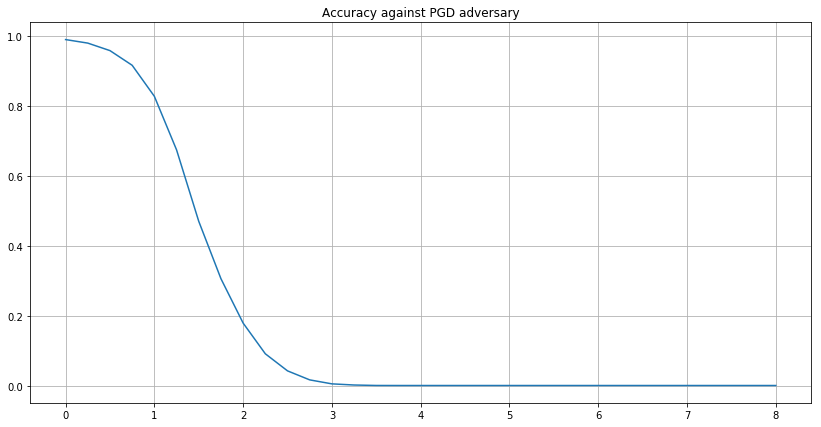

In [17]:
plt.figure(figsize=(14,7))
plt.title('Accuracy against PGD adversary')
plt.plot(pgd_attack_range, pgd_acc)
plt.grid()
plt.show()

# $L_{\infty}$ bounded adversary

L2 distance =  tensor(3.0306, device='cuda:0')
Linf distance =  tensor(0.1500, device='cuda:0')
Adversarial prediction =  tensor([3], device='cuda:0')


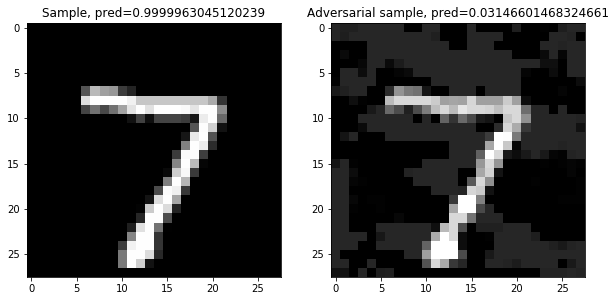

In [18]:
x, y = val[0]
x = x.unsqueeze(0).to(DEVICE)
y = y.unsqueeze(0).to(DEVICE)
x_adv_ifgsm = iterated_fgsm(model, x, y, torch.nn.CrossEntropyLoss(), k=40, step=0.01, eps=0.15, norm='inf')
print('L2 distance = ', (x - x_adv_ifgsm).norm(2))
print('Linf distance = ', (x - x_adv_ifgsm).norm(float('inf')))
print('Adversarial prediction = ', model(x_adv_ifgsm).argmax(dim=1))

fig, axes = plt.subplots(1, 2, figsize=(10,5))

axes[0].imshow(x[0, 0].cpu().numpy(), cmap='gray')
axes[0].set_title(f'Sample, pred={model(x).softmax(dim=1)[0, y].item()}')

axes[1].imshow(x_adv_ifgsm[0, 0].cpu().numpy(), cmap='gray')
axes[1].set_title(f'Adversarial sample, pred={model(x_adv_ifgsm).softmax(dim=1)[0, y].item()}')

plt.show()

In [19]:
def eval_iterated_fgsm(model, k, step, eps):
    total = 0
    acc = 0
    for x, y in val_loader:
        total += x.size(0)

        x_adv = iterated_fgsm(
            model, x.to(DEVICE), y.to(DEVICE), torch.nn.CrossEntropyLoss(), k=k, step=step, eps=eps, norm='inf')

        y_pred = model(x_adv)

        acc += olympic.metrics.accuracy(y.to(DEVICE), y_pred) * x.size(0)

    return acc/total

In [20]:
iter_fgsm_attack_range = np.arange(0.0, 0.52, 0.025)
iter_fgsm_acc = []
for eps in iter_fgsm_attack_range:
    iter_fgsm_acc.append(eval_iterated_fgsm(model, 40, 0.01, eps))

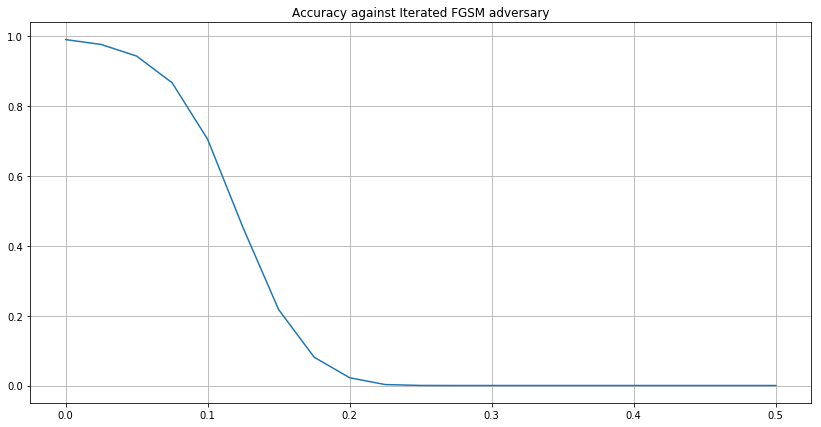

In [21]:
plt.figure(figsize=(14,7))
plt.title('Accuracy against Iterated FGSM adversary')
plt.plot(iter_fgsm_attack_range, iter_fgsm_acc)
plt.grid()
plt.show()

# Adversarial Training

In [26]:
def adversarial_training(model, optimiser, loss_fn, x, y, epoch, adversary, k, step, eps, norm):
    """Performs a single update against a specified adversary"""
    model.train()

    # Adversial perturbation
    x_adv = adversary(model, x, y, loss_fn, k=k, step=step, eps=eps, norm=norm)

    optimiser.zero_grad()
    y_pred = model(x_adv)
    loss = loss_fn(y_pred, y)
    loss.backward()
    optimiser.step()

    return loss, y_pred

In [27]:
adv_model_linf = Net().to(DEVICE)
optimiser = optim.SGD(adv_model_linf.parameters(), lr=0.1)
training_history_linf = olympic.fit(
    adv_model_linf,
    optimiser,
    nn.CrossEntropyLoss(),
    dataloader=train_loader,
    epochs=50,
    metrics=['accuracy'],
    prepare_batch = lambda batch: (batch[0].to(DEVICE), batch[1].to(DEVICE)),
    update_fn=adversarial_training,
    update_fn_kwargs={'adversary': iterated_fgsm,'k': 40, 'step': 0.01, 'eps': 0.3, 'norm': 'inf'},
    callbacks=[
        olympic.callbacks.Evaluate(val_loader),
        olympic.callbacks.ReduceLROnPlateau(patience=5, factor=0.5, min_delta=0.001)
    ]
)

Epoch 1:   0%|          | 0/469 [00:00<?, ?it/s]

Begin training...


Epoch 25: 100%|██████████| 469/469 [00:38<00:00,  6.67it/s, loss=0.321, accuracy=0.894, val_loss=0.118, val_accuracy=0.96]

Finished.


In [39]:
df_linf = pd.DataFrame(training_history_linf)
plt.figure(figsize=(14,7))
plt.plot(df_linf['epoch'], df_linf['accuracy'], label='Adversarial accuracy')
plt.plot(df_linf['epoch'], df_linf['val_accuracy'], label='Natural accuracy')
plt.grid()
plt.legend()
plt.show()

NameError: name 'taFrame' is not defined

In [28]:
adv_model_l2 = Net().to(DEVICE)
optimiser = optim.SGD(adv_model_l2.parameters(), lr=0.1)
training_history_l2 = olympic.fit(
    adv_model_l2,
    optimiser,
    nn.CrossEntropyLoss(),
    dataloader=train_loader,
    epochs=50,
    metrics=['accuracy'],
    prepare_batch = lambda batch: (batch[0].to(DEVICE), batch[1].to(DEVICE)),
    update_fn=adversarial_training,
    update_fn_kwargs={'adversary': pgd, 'k': 40, 'step': 0.1, 'eps': 3.0, 'norm': 2},
    callbacks=[
        olympic.callbacks.Evaluate(val_loader),
        olympic.callbacks.ReduceLROnPlateau(patience=5, factor=0.5, min_delta=0.001)
    ]
)

Epoch 1:   0%|          | 0/469 [00:00<?, ?it/s]

Begin training...


Epoch 25: 100%|██████████| 469/469 [00:45<00:00,  6.10it/s, loss=0.298, accuracy=0.889, val_loss=0.0435, val_accuracy=0.987]

Finished.


In [ ]:
df_l2 = pd.DataFrame(training_history_l2)
plt.figure(figsize=(14,7))
plt.plot(df_l2['epoch'], df_l2['accuracy'], label='Adversarial accuracy')
plt.plot(df_l2['epoch'], df_l2['val_accuracy'], label='Natural accuracy')
plt.grid()
plt.legend()
plt.show()

In [37]:
# Save hardened model
torch.save(adv_model_linf, '../models/mnist_iterated_fgsm_k=40_step=0.01_eps=0.3.pt')
torch.save(adv_model_l2, '../models/mnist_pgd_k=40_step=0.1_eps=3.0.pt')

/home/oscar/PycharmProjects/adversarial/venv/lib/python3.6/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# Test hardened models

### $L_2$ bounded adversary

In [30]:
pgd_acc_linf = []
pgd_acc_l2 = []
for eps in pgd_attack_range:
    pgd_acc_linf.append(eval_pgd_attack(adv_model_linf, 150, eps, 0.25))
    pgd_acc_l2.append(eval_pgd_attack(adv_model_l2, 150, eps, 0.25))

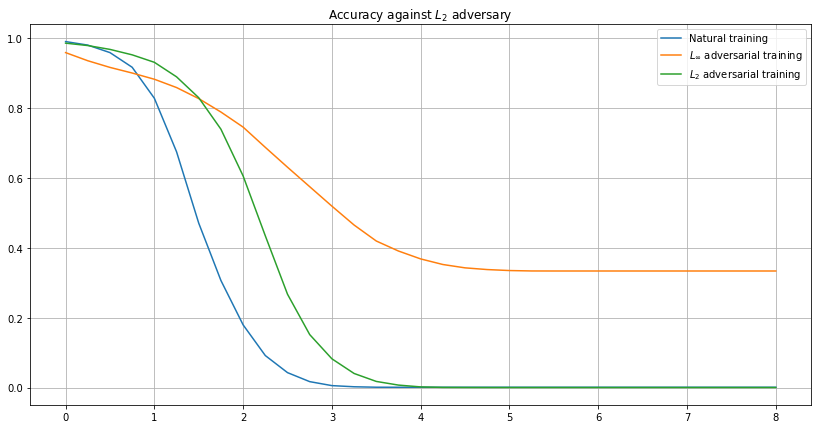

In [32]:
plt.figure(figsize=(14,7))
plt.title('Accuracy against $L_2$ adversary')
plt.plot(pgd_attack_range, pgd_acc, label='Natural training')
plt.plot(pgd_attack_range, pgd_acc_linf, label='$L_{\infty}$ adversarial training')
plt.plot(pgd_attack_range, pgd_acc_l2, label='$L_2$ adversarial training')
plt.legend()
plt.grid()
plt.show()

### $L_{\infty}$ bounded adversary

In [33]:
iter_fgsm_acc_linf = []
iter_fgsm_acc_l2 = []
for eps in iter_fgsm_attack_range:
    iter_fgsm_acc_linf.append(eval_iterated_fgsm(adv_model_linf, 150, 0.01, eps))
    iter_fgsm_acc_l2.append(eval_iterated_fgsm(adv_model_l2, 150, 0.01, eps))

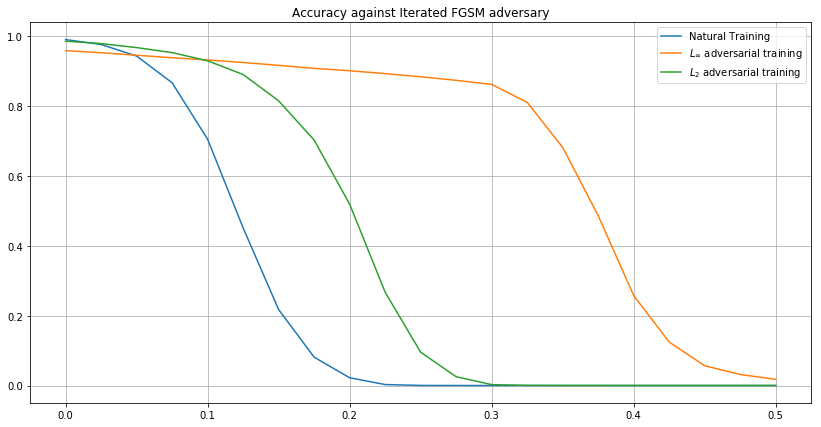

In [34]:
plt.figure(figsize=(14,7))
plt.title('Accuracy against Iterated FGSM adversary')
plt.plot(iter_fgsm_attack_range, iter_fgsm_acc, label='Natural Training')
plt.plot(iter_fgsm_attack_range, iter_fgsm_acc_linf, label='$L_{\infty}$ adversarial training')
plt.plot(iter_fgsm_attack_range, iter_fgsm_acc_l2, label='$L_2$ adversarial training')
plt.legend()
plt.grid()
plt.show()

# Class interpolation
### Untargeted

L2 distance =  tensor(4.9879, device='cuda:0')
Linf distance =  tensor(1., device='cuda:0')
Adversarial prediction =  9


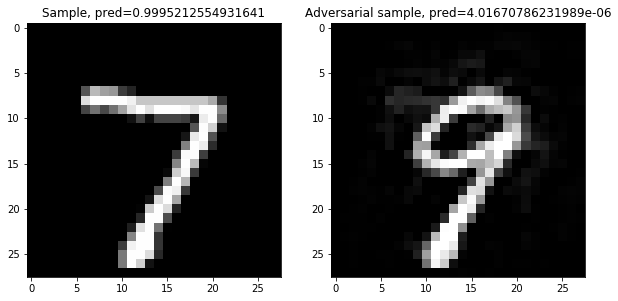

In [42]:
x, y = val[0]
x = x.unsqueeze(0).to(DEVICE)
y = y.unsqueeze(0).to(DEVICE)
x_adv_pgd_hard = pgd(adv_model_l2, x, y, torch.nn.CrossEntropyLoss(), k=120, step=0.25, eps=5, norm=2)
print('L2 distance = ', (x - x_adv_pgd_hard).norm(2))
print('Linf distance = ', (x - x_adv_pgd_hard).norm(float('inf')))
print('Adversarial prediction = ', adv_model_l2(x_adv_pgd_hard).argmax(dim=1).item())
fig, axes = plt.subplots(1, 2, figsize=(10,5))

axes[0].imshow(x[0, 0].cpu().numpy(), cmap='gray')
axes[0].set_title(f'Sample, pred={adv_model_l2(x).softmax(dim=1)[0, y].item()}')

axes[1].imshow(x_adv_pgd_hard[0, 0].cpu().numpy(), cmap='gray')
axes[1].set_title(f'Adversarial sample, pred={adv_model_l2(x_adv_pgd_hard).softmax(dim=1)[0, y].item()}')

plt.show()

### Targeted

8


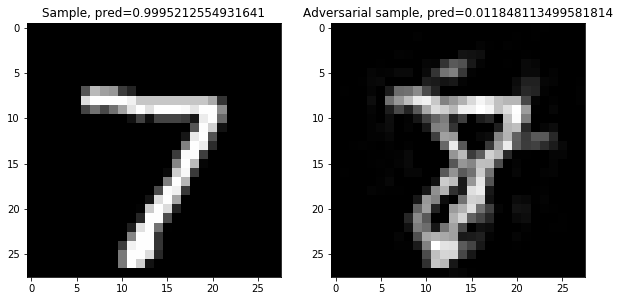

In [65]:
 x_adv_pgd_hard = pgd(adv_model_l2, x, y, torch.nn.CrossEntropyLoss(),
                             k=240, step=0.25, eps=4, norm=2, y_target=torch.Tensor([8]).long().to(DEVICE))
    
print(adv_model_l2(x_adv_pgd_hard).argmax(dim=1).item())
fig, axes = plt.subplots(1, 2, figsize=(10,5))

axes[0].imshow(x[0, 0].cpu().numpy(), cmap='gray')
axes[0].set_title(f'Sample, pred={adv_model_l2(x).softmax(dim=1)[0, y].item()}')

axes[1].imshow(x_adv_pgd_hard[0, 0].cpu().numpy(), cmap='gray')
axes[1].set_title(f'Adversarial sample, pred={adv_model_l2(x_adv_pgd_hard).softmax(dim=1)[0, y].item()}')

plt.show()

In [63]:
def class_interpolations(eps, model_):
    examples = []
    for i in range(10):
        if i != 7:
            x_adv_pgd_hard = pgd(model_, x, y, torch.nn.CrossEntropyLoss(), random=True,
                             k=120, step=0.1, eps=eps, norm=2, y_target=torch.Tensor([i]).long().to(DEVICE))

            examples.append(x_adv_pgd_hard[0, 0].cpu().numpy())
        else:
            examples.append(x[0, 0].cpu().numpy())

    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    fig.suptitle(f'Interpolating with eps={eps}')
    idx = list(range(10))
    idx.remove(7)

    for i, j in enumerate(idx):
        axes[i // 3, i % 3].set_title(f'{y.item()} -> {j}')
        axes[i // 3, i % 3].imshow(examples[j], cmap='gray')
        axes[i // 3, i % 3].set_xticks([])
        axes[i // 3, i % 3].set_yticks([])

    plt.show()

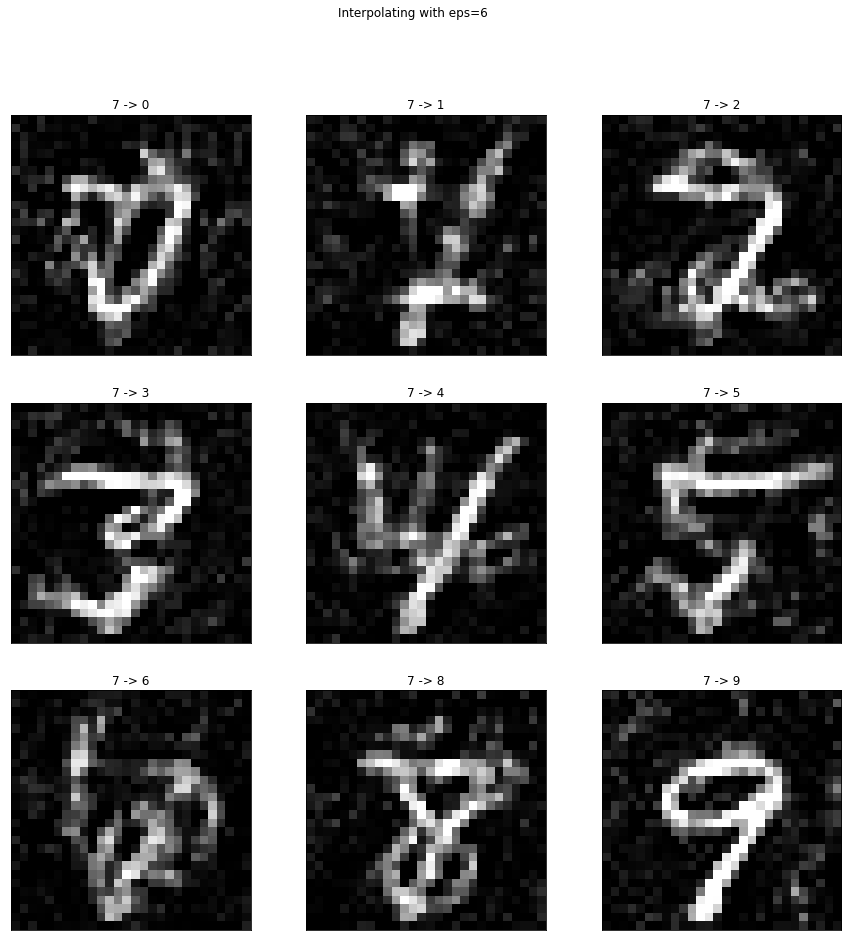

In [58]:
class_interpolations(6, adv_model_l2)

In [50]:
def smoothly_interpolate(model_, target_class, eps_range):
    examples = []
    fig, axes = plt.subplots(1, len(eps_range), figsize=(5*len(eps_range), 5))
    
    for i, eps in enumerate(eps_range):
        x_adv_pgd_hard = pgd(model_, x, y, torch.nn.CrossEntropyLoss(),
                         k=120, step=0.1, eps=eps, norm=2, y_target=torch.Tensor([target_class]).long().to(DEVICE))

        examples.append(x_adv_pgd_hard[0, 0].cpu().numpy())
        
        axes[i].set_title(f'{eps}')
        axes[i].imshow(x_adv_pgd_hard[0,0].cpu().numpy(), cmap='gray')
        axes[i].set_xticks([])
        axes[i].set_yticks([])

    plt.show()

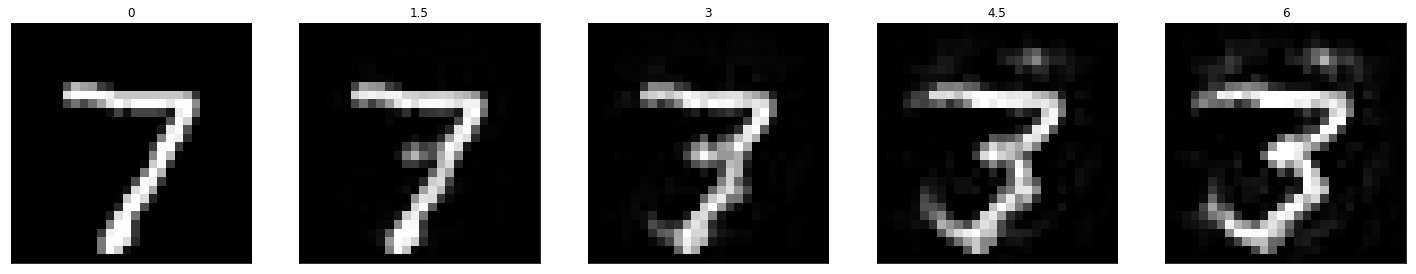

In [51]:
smoothly_interpolate(adv_model_l2, 3, [0, 1.5, 3, 4.5, 6])

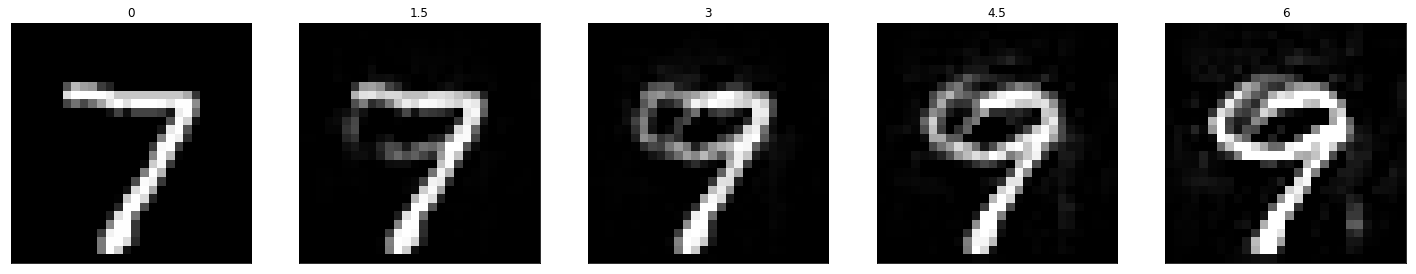

In [52]:
smoothly_interpolate(adv_model_l2, 9, [0, 1.5, 3, 4.5, 6])

# Appendix
### Generate gif 

In [ ]:
# eps_range = np.sin(np.linspace(0, np.pi, 60))*6
# for i_eps, eps in enumerate(eps_range):
#     examples = []
#     for i in range(10):
#         if i != 7:
#             x_adv_pgd_hard = pgd(hard_model, x, y, torch.nn.CrossEntropyLoss(),
#                              k=120, step=0.1, eps=eps, norm=2, y_target=torch.Tensor([i]).long().to(DEVICE))

#             examples.append(x_adv_pgd_hard[0, 0].cpu().numpy())
#         else:
#             examples.append(x[0, 0].cpu().numpy())

#     fig, axes = plt.subplots(3, 3, figsize=(15, 15))
#     idx = list(range(10))
#     idx.remove(7)

#     for i, j in enumerate(idx):
#         axes[i // 3, i % 3].imshow(examples[j], cmap='gray')
#         axes[i // 3, i % 3].set_xticks([])
#         axes[i // 3, i % 3].set_yticks([])
    
#     file_path = f'/home/oscar/Pictures/know-your-enemy/mnist_interpolation/{i_eps}-{np.round(eps, 2)}.png'
#     print(file_path)
#     plt.savefig(file_path)
#     plt.close()